### MMM Data Exploration and Curation
The purpose of this notebook is to explore and lightly curate the monthly min/mean/max (MMM) seaward landfast ice edge (SLIE) extent products for all three 9-year summary periods. These data have been idenitified as high-value summary products by the invovled PIs (Mahoney, Eicken). The data are split into two geographic and analytical zones: the Beaufort Sea and the Chukchi Sea.

In [1]:
from pathlib import Path

import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import Resampling, aligned_target
from rasterio.transform import array_bounds

import eda as eda
from luts import ice_zones, ice_eras, mmm_pixel_values
from config import INPUT_DIR, BEAUFORT_DIR, CHUKCHI_DIR
from preprocess import tap_reproject_mmm_raster

In [2]:
print(f"The three summary periods are {ice_eras}")

The three summary periods are ['1996-2005', '2005-2014', '2014-2023']


In [3]:
# there are loads of different directories in the data source provided by the PIs
# and per conversation with them we want to look in the following locations for the high value MMM summary products
mmm_data_paths = []
for region in ice_zones:
    for era in ice_eras:
        mmm_data_paths.append(Path(INPUT_DIR / region / "AllSeasonsAnalysis2023" / f"MonthlySLIEs_{era}"))

# check a few target directories        
print(mmm_data_paths[0], "\n", mmm_data_paths[-1])

# there should be six directories: 3 eras * 2 zones = 6
assert len(mmm_data_paths) == len(ice_eras) * len (ice_zones)

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 
 /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023


In [4]:
# within each directory, get eyes on the data and check metadata for conformity
help(eda.test_geotiff_metadata_for_conformity)
help(eda.plot_random_sample)

Help on function test_geotiff_metadata_for_conformity in module eda:

test_geotiff_metadata_for_conformity(directory, geotiff_metadata=None, str_to_match=None)
    Test metadata of GeoTIFF files in a directory for conformity.
    Args:
        directory (pathlib.PosixPath): The directory containing GeoTIFF files.
        geotiff_metadata (tuple, optional): A tuple containing a list of GeoTIFF file names and a list of metadata objects. Defaults to None.
        str_to_match (str, optional): A string to match in the file name. Defaults to None.
    Returns:
        dict: A dictionary of metadata objects that do not conform to the random metadata object using the filename as the key.

Help on function plot_random_sample in module eda:

plot_random_sample(directory)
    Plot a single random sample of a GeoTIFF file from a directory.
    
    Args:
        directory (pathlib.PosixPath): The directory containing GeoTIFF files.
    Returns:
        None



/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 is identical.


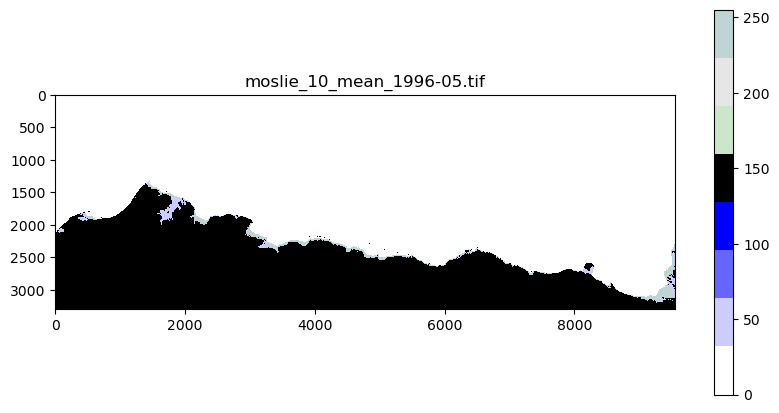

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014 is identical.


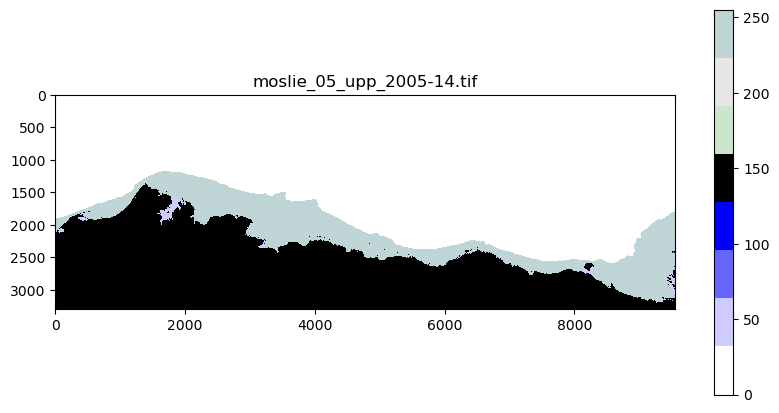

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 is identical.


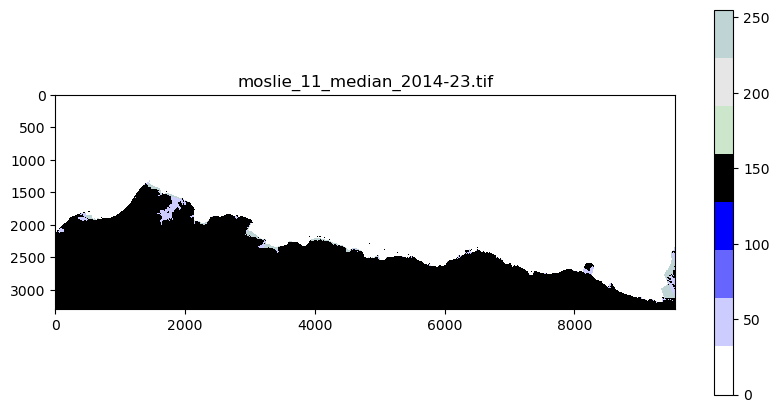

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 is identical.


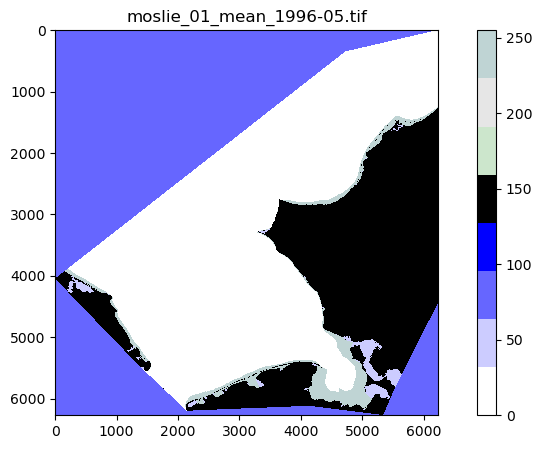

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014 is identical.


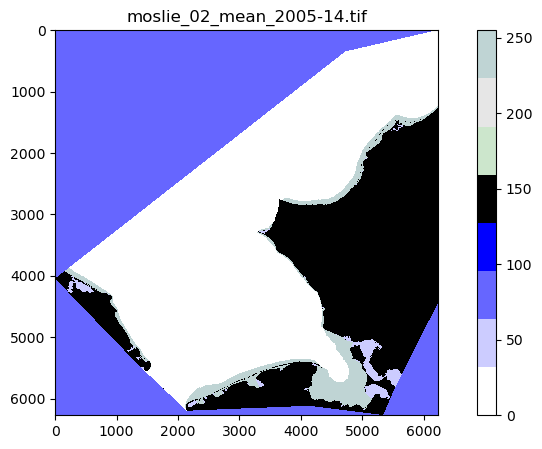

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 is identical.


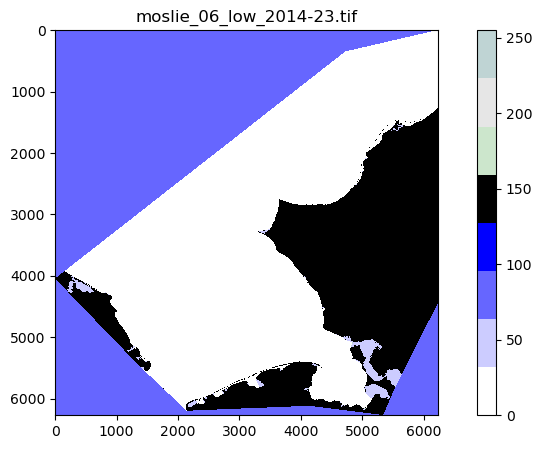

In [5]:
for directory in mmm_data_paths:
    print(directory)
    eda.test_geotiff_metadata_for_conformity(directory, geotiff_metadata=None, str_to_match="MMM")
    eda.plot_random_sample(directory)

Great, so all the MMM metadata is identical. And we can see from the random sample plots (where we are **not** screening for `MMM` only data) some of the constituents of the MMM product: the minimum, the mean, and other dervied extents like `upp` and `LMU`. These more granular products are not needed at this time, but may become useful later on so it is good to know they are here. The next step is to separate out just the `MMM` GeoTIFFs.

In [6]:
# construct a list of the MMM GeoTIFFs across all six directories, ditto for the metadata
mmm_geotiffs_to_ingest = []
metas = []

for directory in mmm_data_paths: 
    tiffs = eda.list_geotiffs(directory, str_to_match="MMM")
    _, meta = eda.fetch_all_geotiff_metadata(directory, str_to_match="MMM")
    mmm_geotiffs_to_ingest = mmm_geotiffs_to_ingest + tiffs
    metas = metas + meta
        
print(mmm_geotiffs_to_ingest[0], "\n", "\n", metas[0], "\n", "\n",)
print(mmm_geotiffs_to_ingest[-1], "\n", "\n", metas[-1], "\n", "\n",)

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005/moslie_06_1996-05_MMM.tif 
 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9554, 'height': 3298, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, -236180.0,
       0.0, -100.0, 2509919.0), 'blockxsize': 960, 'blockysize': 336, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'} 
 

/beeg

Ok so to highlight a few things in the metadata:

**'nodata': None** is a bit unusual. We'll want to verify that is the case.

**AUTHORITY["EPSG","4326"]]** - we'll want to reproject these data to EPSG 3338

**Affine(100.0, 0.0, -236180.0, 0.0, -100.0, 2509919.0)** these data have 100 m resolution - this is expected, but a far finer spatial resolution than we usually work with

**'compress': 'packbits'** not a common compression algorithm in my experience, consider alternatives?

**'transform': Affine(100.0, 0.0, -859401.4481000006, 0.0, -100.0, 2423189.104800001)** - the Chukchi affine transformation has some floating point noise. We can trim this by reprojecting with a `target aligned pixels` parameter.

The reprojection should be straightforward, though we'll want to double check whether or not these data should have a prescribed nodata value and if we can consider a different compression algorithm.

In [7]:
print(f"All MMM values should conform to this set: {mmm_pixel_values}")

All MMM values should conform to this set: {0: 'Ocean', 1: 'Maximum Landfast Ice Extent', 2: 'Median Landfast Ice Extent', 3: 'Minimum Landfast Ice Extent', 4: 'Mean Landfast Ice Edge', 5: 'Land', 6: 'Out of Domain', 7: 'Coast Vector Shadow'}


In [8]:
mmm_expected = list(mmm_pixel_values.keys())

for geotiff in mmm_geotiffs_to_ingest:
    assert eda.validate_values(geotiff, mmm_expected) == True

Great, all values match the expected set. I think to just retain as much fidelity to the original research product, we won't prescribe a "no data" value here. One could argue that "Out of Domain" is a good candidate, but we can omit it for now.

In [9]:
for tiff in mmm_geotiffs_to_ingest:
    tap_reproject_mmm_raster(tiff)

In [10]:
!ls $BEAUFORT_DIR

Beaufort_01_1996-2005_SLIE_MMM_summary.tif
Beaufort_01_2005-2014_SLIE_MMM_summary.tif
Beaufort_01_2014-2023_SLIE_MMM_summary.tif
Beaufort_02_1996-2005_SLIE_MMM_summary.tif
Beaufort_02_2005-2014_SLIE_MMM_summary.tif
Beaufort_02_2014-2023_SLIE_MMM_summary.tif
Beaufort_03_1996-2005_SLIE_MMM_summary.tif
Beaufort_03_2005-2014_SLIE_MMM_summary.tif
Beaufort_03_2014-2023_SLIE_MMM_summary.tif
Beaufort_04_1996-2005_SLIE_MMM_summary.tif
Beaufort_04_2005-2014_SLIE_MMM_summary.tif
Beaufort_04_2014-2023_SLIE_MMM_summary.tif
Beaufort_05_1996-2005_SLIE_MMM_summary.tif
Beaufort_05_2005-2014_SLIE_MMM_summary.tif
Beaufort_05_2014-2023_SLIE_MMM_summary.tif
Beaufort_06_1996-2005_SLIE_MMM_summary.tif
Beaufort_06_2005-2014_SLIE_MMM_summary.tif
Beaufort_06_2014-2023_SLIE_MMM_summary.tif
Beaufort_07_1996-2005_SLIE_MMM_summary.tif
Beaufort_07_2005-2014_SLIE_MMM_summary.tif
Beaufort_07_2014-2023_SLIE_MMM_summary.tif
Beaufort_10_1996-2005_SLIE_MMM_summary.tif
Beaufort_10_2005-2014_SLIE_MMM_summary.tif
Beaufort_10

In [11]:
!ls $CHUKCHI_DIR

Chukchi_01_1996-2005_SLIE_MMM_summary.tif
Chukchi_01_2005-2014_SLIE_MMM_summary.tif
Chukchi_01_2014-2023_SLIE_MMM_summary.tif
Chukchi_02_1996-2005_SLIE_MMM_summary.tif
Chukchi_02_2005-2014_SLIE_MMM_summary.tif
Chukchi_02_2014-2023_SLIE_MMM_summary.tif
Chukchi_03_1996-2005_SLIE_MMM_summary.tif
Chukchi_03_2005-2014_SLIE_MMM_summary.tif
Chukchi_03_2014-2023_SLIE_MMM_summary.tif
Chukchi_04_1996-2005_SLIE_MMM_summary.tif
Chukchi_04_2005-2014_SLIE_MMM_summary.tif
Chukchi_04_2014-2023_SLIE_MMM_summary.tif
Chukchi_05_1996-2005_SLIE_MMM_summary.tif
Chukchi_05_2005-2014_SLIE_MMM_summary.tif
Chukchi_05_2014-2023_SLIE_MMM_summary.tif
Chukchi_06_1996-2005_SLIE_MMM_summary.tif
Chukchi_06_2005-2014_SLIE_MMM_summary.tif
Chukchi_06_2014-2023_SLIE_MMM_summary.tif
Chukchi_07_1996-2005_SLIE_MMM_summary.tif
Chukchi_07_2005-2014_SLIE_MMM_summary.tif
Chukchi_10_1996-2005_SLIE_MMM_summary.tif
Chukchi_10_2005-2014_SLIE_MMM_summary.tif
Chukchi_10_2014-2023_SLIE_MMM_summary.tif
Chukchi_11_1996-2005_SLIE_MMM_summ

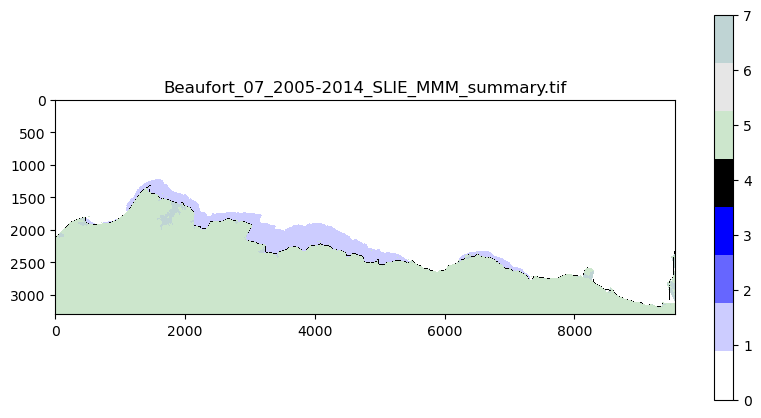

In [12]:
eda.plot_random_sample(BEAUFORT_DIR)

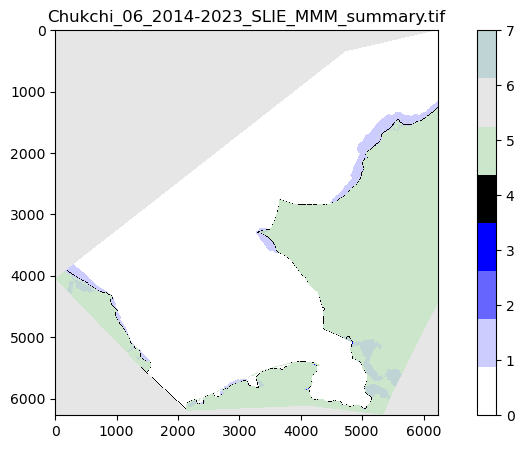

In [13]:
eda.plot_random_sample(CHUKCHI_DIR)

In [16]:
# number of files should 10 months * 3 era in each directory
assert len(eda.list_geotiffs(BEAUFORT_DIR)) == 30

In [17]:
assert len(eda.list_geotiffs(CHUKCHI_DIR)) == 30

AssertionError: 

In [19]:
print(len(eda.list_geotiffs(CHUKCHI_DIR)))

29


Well, after digging in the directory we see that there is no MMM product for July in the most recent era. Until we hear otherwise from the PI we assume that this is because there were not sufficient landfast ice detections during that period.

In [22]:
print([x for x in eda.list_geotiffs(CHUKCHI_DIR) if "07" in x.name])

[PosixPath('/beegfs/CMIP6/cparr4/landfast_sea_ice_products/Chukchi_MMM/Chukchi_07_1996-2005_SLIE_MMM_summary.tif'), PosixPath('/beegfs/CMIP6/cparr4/landfast_sea_ice_products/Chukchi_MMM/Chukchi_07_2005-2014_SLIE_MMM_summary.tif')]


In [25]:
!ls /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 | grep MMM

moslie_01_2014-23_MMM.tif
moslie_02_2014-23_MMM.tif
moslie_03_2014-23_MMM.tif
moslie_04_2014-23_MMM.tif
moslie_05_2014-23_MMM.tif
moslie_06_2014-23_MMM.tif
moslie_10_2014-23_MMM.tif
moslie_11_2014-23_MMM.tif
moslie_12_2014-23_MMM.tif


Above is confirming that there is no July 2014-2023 file within the original source dataset.